# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 17: Generalized Linear Models II. Binomial Logistic Regression and ROC analysis. Regularization of BLR. 

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

In [ ]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - parameters
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()
# - rng
rng = np.random.default_rng()
# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

## 1. Binomial Logistic Regression, ROC analysis.

In [2]:
# - loading the dataset
# - GitHub: https://github.com/dijendersaini/Customer-Churn-Model/blob/master/churn_data.csv
# - place it in your _data/ directory
churn_data = pd.read_csv(os.path.join(data_dir, 'churn_data.csv'))
churn_data.head(10)

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,8,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,22,Yes,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,10,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,28,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,62,Yes,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [4]:
# - use .replace method to replace empty strings with NaN values
churn_data = churn_data.replace(r'^\s*$', np.nan, regex=True)

In [5]:
# - we drop all the entries with missing values
churn_data = churn_data.dropna().reset_index(drop=True)

In [6]:
# - notice that 'TotalCharges' values are non-numeric type, but they should be
# - this is due to the empty string values that were previously present
# - we convert them to numeric type
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype('float')
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   tenure            7032 non-null   int64  
 2   PhoneService      7032 non-null   object 
 3   Contract          7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   Churn             7032 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 494.6+ KB


### Target: Predict churn from all numeric predictors

In [7]:
### --- Preparing the model frame

# - extracting 'Churn' and all the numerical features columns
model_frame = churn_data[['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']]
model_frame.head()

,Churn,tenure,MonthlyCharges,TotalCharges
0,No,1,29.85,29.85
1,No,34,56.95,1889.50
2,Yes,2,53.85,108.15
3,No,45,42.30,1840.75
4,Yes,2,70.70,151.65


In [8]:
# - encoding 'Churn' values to binary values
model_frame['Churn'] = model_frame['Churn'].apply(lambda x: int(x == 'Yes'))
model_frame.head()

,Churn,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,1,2,53.85,108.15
3,0,45,42.30,1840.75
4,1,2,70.70,151.65


In [9]:
predictors = model_frame.columns.drop('Churn')
predictors

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [10]:
# --- Composing the fomula of the model

# - right side of the formula
formula = ' + '.join(predictors)

# - left side of the formula
formula = 'Churn ~ ' + formula

formula

'Churn ~ tenure + MonthlyCharges + TotalCharges'

In [11]:
# - fitting BLR model to the data
binomial_linear_model = smf.logit(formula=formula, data=model_frame).fit()

Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 7


In [12]:
binomial_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7028
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 May 2023   Pseudo R-squ.:                  0.2170
Time:                        20:16:58   Log-Likelihood:                -3188.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5988      0.117    -13.628      0.000      -1.829      -1.369
tenure            -0.0671      0.005    -12.297      0.000      -0.078      -0.056
MonthlyCharges     0.0302      0.002     17.585      0.000       0.027       0.034
TotalCharges       0.0001   6.14e-05      2.361      0.018    2.47e-05       0.000
==================================================================================
"""

In [13]:
# - predicting the probabilities
probabilities = binomial_linear_model.predict()
probabilities[:10]

array([0.31861382, 0.13162129, 0.47723817, 0.04417324, 0.60445587,
       0.72962176, 0.47459352, 0.2095354 , 0.53216748, 0.02770232])

In [14]:
# - predicting binary labels, taking \sigma = 0.5
predictions = (probabilities > .5).astype('int')
predictions[:10]

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [15]:
# - observed vs. predicted labels

predictions_df = pd.DataFrame()

predictions_df['observation'] = model_frame['Churn']
predictions_df['prediction'] = predictions

predictions_df.head()

,observation,prediction
0,0,0
1,0,0
2,1,0
3,0,0
4,1,1


In [16]:
# - model true positive rate (hit rate)
hit = (predictions_df['observation'] == 1)&(predictions_df['prediction'] == 1)
hit = np.sum(hit)/np.sum(predictions_df['observation'] == 1)
np.round(hit, 4)

0.4425

In [17]:
# - model false positive rate (fallse alarm rate)
fa = (predictions_df['observation'] == 0)&(predictions_df['prediction'] == 1)
fa = np.sum(fa)/np.sum(predictions_df['observation'] == 0)
np.round(fa, 4)

0.091

NOTE: Ubaci Miss Rate i Correct Rejection.

In [18]:
### --- Constructing the ROC curve of the model

# - calculating model metrics for varying decision criteria \sigma
dec_criterion = np.arange(.01, .99, step=.01)

observations = model_frame['Churn']

hits = []
fas = []
accuracies = []

for x in dec_criterion:
    
    predictions =  probabilities > x
    
    accuracy = np.sum(observations == predictions)/len(observations)
    hit = np.sum((observations == 1)&(predictions == 1))/np.sum(observations == 1)
    fa = np.sum((observations == 0)&(predictions == 1))/np.sum(observations == 0)
    
    accuracies.append(accuracy)
    fas.append(fa)
    hits.append(hit)

In [19]:
roc_frame = pd.DataFrame()

roc_frame['hit'] = hits
roc_frame['fa'] = fas
roc_frame['accuracy'] = accuracies
roc_frame['dec'] = dec_criterion

roc_frame.head()

,hit,fa,accuracy,dec
0,0.998930,0.935890,0.312571,0.01
1,0.993579,0.889793,0.344994,0.02
2,0.989834,0.847182,0.375284,0.03
3,0.987694,0.809413,0.402446,0.04
4,0.979668,0.771063,0.428470,0.05


In [20]:
# - difference between the hit and false alarm rates
roc_frame['diff'] = roc_frame['hit'] - roc_frame['fa']
roc_frame.head()

,hit,fa,accuracy,dec,diff
0,0.998930,0.935890,0.312571,0.01,0.063040
1,0.993579,0.889793,0.344994,0.02,0.103787
2,0.989834,0.847182,0.375284,0.03,0.142652
3,0.987694,0.809413,0.402446,0.04,0.178281
4,0.979668,0.771063,0.428470,0.05,0.208605


In [21]:
# - identifying the entry with the highest hit-false alarm rate difference
diff_argmax = roc_frame['diff'].argmax()
diff_argmax

24

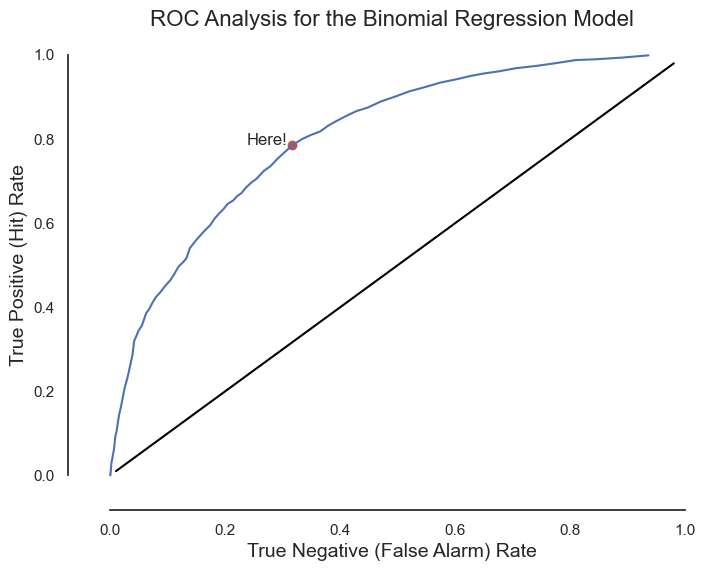

In [22]:
# - plotting the ROC curve of the model
# - the point with the biggest hit-false alarm rate difference is marked
sns.lineplot(data=roc_frame, x='dec', y='dec', color='black')
sns.lineplot(data=roc_frame, x='fa', y='hit')

plt.scatter(x=roc_frame.loc[diff_argmax, 'fa'], y=roc_frame.loc[diff_argmax, 'hit'], c='r')
plt.text(x=roc_frame.loc[diff_argmax, 'fa']-.08, y=roc_frame.loc[diff_argmax, 'hit'], s='Here!')

sns.despine(offset=10, trim=True)
plt.xlabel('True Negative (False Alarm) Rate', fontsize=14)
plt.ylabel('True Positive (Hit) Rate', fontsize=14)
plt.title('ROC Analysis for the Binomial Regression Model', fontsize=16);

### The Akaike Information Criterion (AIC)

The Akaike Information Criterion (AIC) is a statistical measure used to evaluate the goodness-of-fit of a model. It is based on the principle of parsimony, which states that simpler models should be preferred over more complex ones, all else being equal.

The AIC is defined as follows:

$$AIC = -2\ln(\mathcal{L}) + 2k $$

where $\mathcal{L}$ is the model likelihood and $k$ is the number of parameters in the model.

The AIC penalizes models with more parameters, by adding a penalty term $2k$ to the log-likelihood $-2\ln(\mathcal{L})$. This penalty term is larger for models with more parameters, and hence it discourages overfitting and encourages simpler models.

The AIC can be used to compare different models and select the best one based on their AIC values. The model with the lowest AIC value is preferred, as it strikes a good balance between goodness-of-fit and simplicity.

In [23]:
# - Akaike Information Criterion (AIC)
binomial_linear_model.aic

6384.226174634843

In [24]:
# - another way to compute AIC
model_loglike = binomial_linear_model.llf
model_loglike
aic = -2*model_loglike + 2*len(predictors)
aic

6382.226174634843

Model effect: comparison to the Null Model

In [25]:
# - Log-likelihood of model
model_loglike = binomial_linear_model.llf
model_loglike

-3188.1130873174216

In [26]:
# Value of the constant-only loglikelihood
null_loglike = binomial_linear_model.llnull
null_loglike

-4071.6775733255813

In [27]:
# - Comparison to the Null Model which follows the Chi-Square distribution

# - differece between deviances of the Null Model and our model:
# - Likelihood ratio chi-squared statistic; -2*(llnull - llf)
dev_diff = binomial_linear_model.llr
dev_diff

1767.1289720163195

Ovo ispod je Chi-Sq, testiraj npr.

In [28]:
-2*(null_loglike - model_loglike)

1767.1289720163195

### Target: Predict churn from all the predictors

In [29]:
# - exponential of the parameters and AIC of the model using only numerical predictors (a reminder)
np.exp(binomial_linear_model.params)

Intercept         0.202133
tenure            0.935088
MonthlyCharges    1.030660
TotalCharges      1.000145
dtype: float64

In [30]:
binomial_linear_model.aic

6384.226174634843

In [31]:
### --- Prepering the dataset

# - droping the 'customerID' column
model_frame = churn_data.drop(columns='customerID')
model_frame.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,34,Yes,One year,No,Mailed check,56.95,1889.50,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [32]:
model_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tenure            7032 non-null   int64  
 1   PhoneService      7032 non-null   object 
 2   Contract          7032 non-null   object 
 3   PaperlessBilling  7032 non-null   object 
 4   PaymentMethod     7032 non-null   object 
 5   MonthlyCharges    7032 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   Churn             7032 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 439.6+ KB


In [ ]:
### --- Preparing the dataset

# - droping the 'customerID' column
model_frame = churn_data.drop(columns='customerID')
model_frame.head()

In [ ]:
# - encoding 'Churn' column to binary values
model_frame['Churn'] = model_frame['Churn'].apply(lambda x: int(x == 'Yes'))
model_frame.head()

In [ ]:
predictors = model_frame.columns.drop('Churn')
predictors

In [ ]:
# --- Composing the fomula of the model

# - right side of the formula
formula = ' + '.join(predictors)

# - left side of the formula
formula = 'Churn ~ ' + formula

formula

In [ ]:
# - fitting BLR model to the data
binomial_linear_model = smf.logit(formula=formula, data=model_frame).fit()

In [ ]:
binomial_linear_model.summary()

In [ ]:
# - exponentials of the new model parameters
np.exp(binomial_linear_model.params)

In [ ]:
# - AIC of the new model
binomial_linear_model.aic

In [ ]:
### --- Constructing the ROC curve of the model

# - calculating model metrics for varying decision criteria \sigma
dec_criterion = np.arange(.01, .99, step=.01)

probabilities = binomial_linear_model.predict()
observations = model_frame['Churn']

hits = []
fas = []
accuracies = []

for x in dec_criterion:
    
    predictions =  probabilities > x
    
    accuracy = np.sum(observations == predictions)/len(observations)
    hit = np.sum((observations == 1)&(predictions == 1))/np.sum(observations == 1)
    fa = np.sum((observations == 0)&(predictions == 1))/np.sum(observations == 0)
    
    accuracies.append(accuracy)
    fas.append(fa)
    hits.append(hit)

In [ ]:
roc_frame = pd.DataFrame()

roc_frame['hit'] = hits
roc_frame['fa'] = fas
roc_frame['accuracy'] = accuracies
roc_frame['dec'] = dec_criterion
roc_frame['diff'] = roc_frame['hit'] - roc_frame['fa']

roc_frame.head()

In [ ]:
# - identifying the entry with the highest hit-false alarm rate difference
diff_argmax = roc_frame['diff'].argmax()
diff_argmax

In [ ]:
# - plotting the ROC curve of the model
# - the point with the biggest hit-false alarm rate difference is marked
sns.lineplot(data=roc_frame, x='dec', y='dec', color='black')
sns.lineplot(data=roc_frame, x='fa', y='hit')

plt.scatter(x=roc_frame.loc[diff_argmax, 'fa'], y=roc_frame.loc[diff_argmax, 'hit'], c='r')
plt.text(x=roc_frame.loc[diff_argmax, 'fa']-.08, y=roc_frame.loc[diff_argmax, 'hit'], s='Here!')

sns.despine(offset=10, trim=True)
plt.xlabel('True Negative (False Alarm) Rate', fontsize=14)
plt.ylabel('True Positive (Hit) Rate', fontsize=14)
plt.title('ROC Analysis for the Binomial Regression Model', fontsize=16);

## 2. BLR using scikit-learn

### Target: Predicting churn from numerical predictors

In [ ]:
# - import scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
### --- Preparing the variables 

# - feature matrix
X = churn_data[['tenure', 'MonthlyCharges', 'TotalCharges']].values

# - target variable
y = churn_data['Churn'].apply(lambda x: int(x == 'Yes'))

In [ ]:
## --- Fitting the logistic model to the numerical data
log_reg = LogisticRegression()
log_reg.fit(X, y)

In [ ]:
# - coefficients of the model
log_reg.coef_, log_reg.intercept_

In [ ]:
# - coefficients of the model
log_reg.coef_, log_reg.intercept_

In [ ]:
# - model's accuracy
round(log_reg.score(X, y), 4)

In [ ]:
# - confusion matrix for the given data
y_pred = log_reg.predict(X)
confusion_matrix(y, y_pred)

### Target: Predicting churn from all the predictors

In [ ]:
churn_data.head()

In [ ]:
### --- Composing the feature matrix

# - dropping all the non-numerical and non-binary categorical columns
X0 = churn_data.drop(columns=['customerID', 'Contract', 'PaymentMethod', 'Churn'])

# - encoding binary categorical features to binary values
X0['PaperlessBilling'] = X0['PaperlessBilling'].apply(lambda x: int(x == 'Yes'))
X0['PhoneService'] = X0['PhoneService'].apply(lambda x: int(x == 'Yes'))

X0.head()

In [ ]:
# - casting the data frame into a matrix
X0 = X0.values
X0

In [ ]:
# - categories of the 'Contract' variable
churn_data['Contract'].unique()

In [ ]:
# - categories of the 'PaymentMethod' variable
churn_data['PaymentMethod'].unique()

In [ ]:
# - we want to recreate the previous statsmodels model that was using all the predictors
# - to achieve this we one-hot (dummy) encode non-binary categorical predictors
# - statsmodels chooses the first category in order of appearance in the dataset as the reference category
# - we pass the reference category manually as an argument to the OneHotEncoder

enc_contract = OneHotEncoder(drop=['Month-to-month'], sparse=False)
dummy_contract = enc_contract.fit_transform(churn_data['Contract'].values.reshape(-1, 1))

enc_payment = OneHotEncoder(drop=['Bank transfer (automatic)'], sparse=False)
dummy_payment = enc_payment.fit_transform(churn_data['PaymentMethod'].values.reshape(-1, 1))

In [ ]:
# - concatenating values of the numerical predictors and encoded binary values with the encoded non-binary values
# - into a feature matrix
X = np.concatenate((X0, dummy_contract, dummy_payment), axis=-1)
display(X)

# - target variable; encoding to binary values
y = churn_data['Churn'].apply(lambda x: int(x == 'Yes'))

In [ ]:
### --- Fitting the logistic model to all the data
log_reg = LogisticRegression(solver='newton-cg', penalty='none')
log_reg.fit(X, y)

In [ ]:
# - model's accuracy
round(log_reg.score(X, y), 4)

In [ ]:
# - exponential of the model parameters
# - ordering corresponds to the ordering of the features in the feature matrix
np.exp(log_reg.coef_), np.exp(log_reg.intercept_)

In [ ]:
# - confusion matrix for the given data
y_pred = log_reg.predict(X)
confusion_matrix(y, y_pred)

## 3. Regularization of BLR

### Further Reading

***